<h1><center>ASHRAE - Great Energy Predictor III - Feature Engineering💡</center></h1>

# Libraries 📚

In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Read data from interim files

In [2]:
%%time
train_df = pd.read_feather("../data/interim/train.feather")
test_df = pd.read_feather("../data/interim/test.feather")
weather_train_df = pd.read_feather("../data/interim/weather_train.feather")
weather_test_df = pd.read_feather("../data/interim/weather_test.feather")
building_metadata_df = pd.read_feather("../data/interim/building_metadata.feather")
sample_submission_df = pd.read_feather("../data/interim/sample_submission.feather")

CPU times: user 1.91 s, sys: 3.28 s, total: 5.19 s
Wall time: 5.99 s


In [3]:
leak_df = pd.read_feather("../data/interim/post_featureEng/leak.feather")
#https://www.kaggle.com/yamsam/ashrae-leak-data-station/data#site-4

### Correct Timestamp

In [4]:
def correct_timestamp_dtype(df):
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

In [5]:
weather_train_df = correct_timestamp_dtype(weather_train_df)
train_df = correct_timestamp_dtype(train_df)
weather_test_df = correct_timestamp_dtype(weather_test_df)
test_df = correct_timestamp_dtype(test_df)

### Reduce Memory

In [6]:
#import pandas as pd
def reduce_mem_df(df):
    df_mem_before = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(df_mem_before))
    
    for col in df.columns:
        if df[col].dtype == 'datetime64' or pd.api.types.is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif str(col_type)[:5] == "float":
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    df_mem_after = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(df_mem_after))
    print("Decreased by {:.1f}%".format(100 * (df_mem_before - df_mem_after) / df_mem_before))
    
    return df

In [7]:
weather_train_df = reduce_mem_df(weather_train_df)
weather_test_df = reduce_mem_df(weather_test_df)
building_metadata_df = reduce_mem_df(building_metadata_df)
train_df = reduce_mem_df(train_df)
test_df = reduce_mem_df(test_df)

Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 4.93 MB
Decreased by 48.6%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 9.78 MB
Decreased by 48.6%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 65.6%
Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 289.19 MB
Decreased by 53.1%
Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 596.49 MB
Decreased by 53.1%


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          int8          
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB


In [9]:
leak_df = reduce_mem_df(leak_df)

Memory usage of dataframe is 512.70 MB
Memory usage after optimization is: 288.39 MB
Decreased by 43.7%


In [10]:
leak_df.info(),test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800125 entries, 0 to 16800124
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          float32       
 2   meter_reading  float32       
 3   timestamp      datetime64[ns]
dtypes: datetime64[ns](1), float32(2), int16(1)
memory usage: 288.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   row_id       int32         
 1   building_id  int16         
 2   meter        int8          
 3   timestamp    datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(1), int8(1)
memory usage: 596.5 MB


(None, None)

In [11]:
test_df.drop(columns='row_id',inplace=True)

In [12]:
leak_df['meter'] = leak_df['meter'].astype(np.int8)

### Add leak data

In [13]:
leak_df = leak_df.drop_duplicates(['building_id','meter','timestamp'])

In [14]:
train_df = train_df.merge(leak_df,how='left',on=['building_id','meter','timestamp'],suffixes=(None,"_leak"))

In [15]:
train_df.loc[(~train_df.meter_reading_leak.isna()),'meter_reading'] = train_df[~train_df.meter_reading_leak.isna()]['meter_reading_leak']

In [16]:
train_df.drop(columns='meter_reading_leak',inplace=True)

In [17]:
#test_df = test_df.merge(leak_df,how='left',on=['building_id','meter','timestamp'],suffixes=(None,"_leak"))

### Adjust outliers

In [18]:
def print_outliers_weather(weather_df,factor,q1,q3):
    cols=['air_temperature','dew_temperature','precip_depth_1_hr','cloud_coverage','wind_speed','wind_direction','sea_level_pressure']
    for site  in range(16):
        for col in cols:
            _df = weather_df[weather_df.site_id == site]
            Q1 = _df[col].quantile(q1)
            Q3 = _df[col].quantile(q3)
            IQR = Q3 - Q1
            per_outliers = (len(_df[_df[col] < Q1 - factor * IQR])/len(_df))*100 + (len(_df[_df[col] > Q3 + factor * IQR])/len(_df))*100
            if per_outliers > 2:
                print("% outliers for site-" + str(site) + " & " + col + " = " + str(per_outliers))
    #return weather_df

In [19]:
print_outliers_weather(weather_train_df,2.5,0.25,0.75)

% outliers for site-0 & precip_depth_1_hr = 9.50591985428051
% outliers for site-2 & precip_depth_1_hr = 2.493453261983377
% outliers for site-3 & precip_depth_1_hr = 12.699316628701595
% outliers for site-4 & precip_depth_1_hr = 6.501195491289992
% outliers for site-6 & precip_depth_1_hr = 11.01115918925074
% outliers for site-6 & cloud_coverage = 12.104304258711
% outliers for site-8 & precip_depth_1_hr = 9.50591985428051
% outliers for site-9 & precip_depth_1_hr = 8.439635535307517
% outliers for site-9 & cloud_coverage = 12.574031890660592
% outliers for site-10 & precip_depth_1_hr = 9.781370986107948
% outliers for site-10 & cloud_coverage = 7.401503074470509
% outliers for site-13 & precip_depth_1_hr = 14.664693157235568
% outliers for site-14 & precip_depth_1_hr = 11.154152899624018
% outliers for site-14 & cloud_coverage = 10.481941437848924


As the % outliers for precipitation and cloud coverage is more than 10% for some sites and 
knowing that the data is sparse we will re-evaluate the outlier criteria and make it 5*IQR

In [20]:
print_outliers_weather(weather_train_df,2.5,0.05,0.95)

% outliers for site-0 & precip_depth_1_hr = 9.50591985428051
% outliers for site-2 & precip_depth_1_hr = 2.493453261983377
% outliers for site-8 & precip_depth_1_hr = 9.50591985428051
% outliers for site-9 & precip_depth_1_hr = 8.439635535307517
% outliers for site-10 & precip_depth_1_hr = 4.588931906171715


In [21]:
#weather_train_df = adjust_outliers_weather(weather_train_df)
#weather_test_df = adjust_outliers_weather(weather_test_df)

### Exploring weather_train_df with plotly express and ipywidgets

In [22]:
from ipywidgets import interact,widgets
import plotly.express as px
import plotly.io as pio
pio.renderers.default="jupyterlab"
import plotly.graph_objects as go
import time

In [23]:
site_wid  = widgets.SelectMultiple(
            options=[i for i in range(16)],
            value=[],
            description='Site:',
            disabled=False,
            )

cols=['air_temperature','dew_temperature','precip_depth_1_hr','cloud_coverage','wind_speed','wind_direction','sea_level_pressure']
weather_wid = widgets.SelectMultiple(
            options=[i for i in cols],
            value=[],
            description='Weather:',
            disabled=False,
            )

In [24]:
layout = go.Layout(title="Weather readings",
                xaxis_title="Timestamp",
                yaxis_title="Weather Readings",
                legend_title="Weather")
fig_weather = go.FigureWidget(layout = layout)

for weather_col in cols:
    for site in range(16):
        site_df = weather_train_df[weather_train_df.site_id == site][["timestamp",weather_col]]
        fig_weather.add_trace(go.Scatter(x=site_df["timestamp"], y=site_df[weather_col],line={},\
                             name = "st" + str(site) + "_" + weather_col ,meta=[site,weather_col], visible=False))

In [25]:
def response_weather(change):
    fig_weather.update_traces(visible=False)
    for weather_col in weather_wid.value:
        for site in site_wid.value:
            fig_weather.update_traces(visible=True,selector=dict(meta=(site,weather_col)))

In [26]:
site_wid.observe(response_weather, names="value")
weather_wid.observe(response_weather, names="value")
hbox = widgets.HBox([weather_wid,site_wid])
vbox = widgets.VBox([hbox,fig_weather])
vbox

In [27]:
#vbox.close()

#### After looking at the weather data more closely , it is clear that the outliers are due to the data being sparse and aren't really outliers.

## Fill missing weather data

In [28]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [29]:
def fill_missing_weather(weather_df):
    weather_df = weather_df.set_index(['site_id','timestamp']).unstack(0)
    weather_df = weather_df.resample('H').interpolate(limit_direction='both')
    weather_df = weather_df.stack()
    weather_df.fillna(weather_df.groupby('timestamp').mean(),inplace=True)
    weather_df.reset_index(inplace=True)
    return weather_df

In [30]:
weather_train_df = fill_missing_weather(weather_train_df)
weather_test_df = fill_missing_weather(weather_test_df)

In [31]:
def fill_missing_building_metadata(df):
    df['year_built'] = df['year_built'].fillna(building_metadata_df['year_built'].min())
    df['floor_count'] = df['floor_count'].fillna(0)
    return df

In [32]:
building_metadata_df = fill_missing_building_metadata(building_metadata_df)

In [33]:
building_metadata_df.isna().sum()

site_id        0
building_id    0
primary_use    0
square_feet    0
year_built     0
floor_count    0
dtype: int64

In [34]:
"""
import plotly

train_build_df = train_build_df[train_build_df.timestamp < '2016-06-01']

import plotly.io as pio
pio.renderers.default="jupyterlab"

import plotly.graph_objects as go

from ipywidgets import widgets

figw = go.FigureWidget()

default_meter = 0
default_site = 0

sites = [i for i in range(16)]
buttons_site = []
buttons_meter = []

default_site = 0
meters = [i for i in range(4)]
default_meter = 0
_df = train_build_df[["meter","site_id","building_id"]].drop_duplicates().\
    sort_values(by=["meter","site_id","building_id"])

for meter in meters:
    for site_id in sites:
        site_name = 'site_' + str(site_id)
        site_readings = train_build_df[(train_build_df.meter == meter) & (train_build_df.site_id==site_id)]\
                        [["timestamp","building_id","meter_reading"]].sort_values(by=["building_id","timestamp"])
    
        # add a scatter trace
        for building_id in (site_readings.building_id.unique()):
            site_bg_readings = site_readings[site_readings.building_id == building_id]
            figw.add_trace(go.Scatter(x=site_bg_readings["timestamp"], y=site_bg_readings["meter_reading"],line={},\
                             name = str(site_id) + "_" + str(meter) , visible=(site_id==default_site)))


meter_dropdwn = widgets.Dropdown(
    options=[i for i in range(4)],
    value=0,
    description='Meter Type:',
)

site_dropdwn = widgets.Dropdown(
    options=[i for i in range(16)],
    value=0,
    description='Site ID:',
)

def response(change):
    site_id = site_dropdwn.value
    meter = meter_dropdwn.value
    #with g.batch_update():
    figw.update_traces(visible=False)
    figw.update_traces(visible=True,selector=dict(name=str(site_id) + "_" + str(meter)))

meter_dropdwn.observe(response, names="value")
site_dropdwn.observe(response, names="value")

widgets.VBox([figw,widgets.HBox([meter_dropdwn, site_dropdwn])])
"""

'\nimport plotly\n\ntrain_build_df = train_build_df[train_build_df.timestamp < \'2016-06-01\']\n\nimport plotly.io as pio\npio.renderers.default="jupyterlab"\n\nimport plotly.graph_objects as go\n\nfrom ipywidgets import widgets\n\nfigw = go.FigureWidget()\n\ndefault_meter = 0\ndefault_site = 0\n\nsites = [i for i in range(16)]\nbuttons_site = []\nbuttons_meter = []\n\ndefault_site = 0\nmeters = [i for i in range(4)]\ndefault_meter = 0\n_df = train_build_df[["meter","site_id","building_id"]].drop_duplicates().    sort_values(by=["meter","site_id","building_id"])\n\nfor meter in meters:\n    for site_id in sites:\n        site_name = \'site_\' + str(site_id)\n        site_readings = train_build_df[(train_build_df.meter == meter) & (train_build_df.site_id==site_id)]                        [["timestamp","building_id","meter_reading"]].sort_values(by=["building_id","timestamp"])\n    \n        # add a scatter trace\n        for building_id in (site_readings.building_id.unique()):\n        

In [35]:
"""
fig = go.Figure()

sites = [i for i in range(16)]
buttons_site = []
buttons_meter = []

default_site = 0
meters = [i for i in range(4)]
default_meter = 0

_df = train_build_df[["meter","site_id","building_id"]].drop_duplicates().\
    sort_values(by=["meter","site_id","building_id"])

for meter in meters:
    for site_id in sites:
        site_name = 'site_' + str(site_id)
        site_readings = train_build_df[(train_build_df.meter == meter) & (train_build_df.site_id==site_id)]\
                        [["timestamp","building_id","meter_reading"]].sort_values(by=["building_id","timestamp"])
    
        # add a scatter trace
        for building_id in (site_readings.building_id.unique()):
            site_bg_readings = site_readings[site_readings.building_id == building_id]
            fig.add_trace(go.Scatter(x=site_bg_readings["timestamp"], y=site_bg_readings["meter_reading"],line={},\
                             name = "building_"  + str(building_id) , visible=(site_id==default_site)))

for site_id in sites:
    site_name = 'site_' + str(site_id)
    buttons_site.append(dict(method='update',label=site_name,args = [{'visible': (_df.site_id == site_id).to_list()}]))

for meter in meters:
    buttons_meter.append(dict(method='update',label=str(meter),args = [{'visible': (_df.meter == meter ).to_list()}]))

# Add dropdown menus to the figure
fig.update_layout(showlegend=True, updatemenus=[{"buttons": buttons_meter, "direction": "down", "active":\
                                                  meters.index(default_meter), "showactive": True, "x": 0.29, "y": 1.15}
                                               ,{"buttons": buttons_site, "direction": "down", "active":\
                                                  sites.index(default_site), "showactive": True, "x": 0.45, "y": 1.15}])
fig.update_layout(
    annotations=[
        dict(text="Meter Type", x=0.15, xref="paper", y=1.09, yref="paper",
                             align="left", showarrow=False),
        dict(text="Site", x=0.30, xref="paper", y=1.09,
                             yref="paper", showarrow=False),
    ])

fig.show()
"""

'\nfig = go.Figure()\n\nsites = [i for i in range(16)]\nbuttons_site = []\nbuttons_meter = []\n\ndefault_site = 0\nmeters = [i for i in range(4)]\ndefault_meter = 0\n\n_df = train_build_df[["meter","site_id","building_id"]].drop_duplicates().    sort_values(by=["meter","site_id","building_id"])\n\nfor meter in meters:\n    for site_id in sites:\n        site_name = \'site_\' + str(site_id)\n        site_readings = train_build_df[(train_build_df.meter == meter) & (train_build_df.site_id==site_id)]                        [["timestamp","building_id","meter_reading"]].sort_values(by=["building_id","timestamp"])\n    \n        # add a scatter trace\n        for building_id in (site_readings.building_id.unique()):\n            site_bg_readings = site_readings[site_readings.building_id == building_id]\n            fig.add_trace(go.Scatter(x=site_bg_readings["timestamp"], y=site_bg_readings["meter_reading"],line={},                             name = "building_"  + str(building_id) , visible=(

## Merge train_df and building_metadata_df

In [36]:
train_build_df = train_df.merge(building_metadata_df,how='left',on='building_id')

### Exploring train_build_df with plotly express and ipywidgets

In [37]:
meter_wid = widgets.Dropdown(
            options=[i for i in range(4)],
            value=0,
            description='Meter:',
            disabled=False,
            )
site_wid  = widgets.Dropdown(
            options=[i for i in range(16)],
            value=0,
            description='Site:',
            disabled=False,
            )

In [38]:
_df = train_build_df
_df = _df[(_df.site_id == site_wid.value) & (_df.meter == meter_wid.value)].sort_values(['site_id','building_id','meter','timestamp'])
layout = go.Layout(title="Meter readings for Site-" + str(site_wid.value) + " & meter-" + str(meter_wid.value),
                xaxis_title="Timestamp",
                yaxis_title="Meter Readings",
                legend_title="Building_IDs")
fig = go.FigureWidget(layout = layout)
#px.line(x=_df['timestamp'],y=_df['meter_reading'],color=_df['building_id']))

for building_id in _df.building_id.unique():
    site_bg_readings = _df[_df.building_id == building_id]
    fig.add_trace(go.Scatter(x=site_bg_readings["timestamp"], y=site_bg_readings["meter_reading"],line={},\
                             name = "building_"  + str(building_id) , visible=True))

In [39]:
def response(change):
    global fig
    _df = train_build_df
    _df = _df[(_df.site_id == site_wid.value) & (_df.meter == meter_wid.value)].sort_values(['site_id','building_id','meter','timestamp'])
    if len(_df.index) == 0:
        fig.data = []
        fig.update_layout(title="No meter readings for Site-" + str(site_wid.value) + " & meter-" + str(meter_wid.value))
    else:
        fig.data = []
        time.sleep(2)
        for building_id in _df.building_id.unique():
            site_bg_readings = _df[_df.building_id == building_id]
            fig.add_trace(go.Scatter(x=site_bg_readings["timestamp"], y=site_bg_readings["meter_reading"],line={},\
                             name = "building_"  + str(building_id) , visible=True))
            fig.update_layout(title="Meter readings for Site-" + str(site_wid.value) + " & meter-" + str(meter_wid.value),
                            xaxis_title="Timestamp",
                            yaxis_title="Meter Readings",
                            legend_title="Building_IDs")

In [40]:
meter_wid.observe(response, names="value")
site_wid.observe(response, names="value")

meter_site_hbox = widgets.HBox([meter_wid,site_wid])
vbox = widgets.VBox([meter_site_hbox,fig])
vbox

In [80]:
#vbox.close()

## Remove incorrect meter reading data

#### remove site 0 incorrect data

In [55]:
len(train_build_df[(train_build_df.site_id == 0) & (train_build_df.meter == 0) & (train_build_df.timestamp < '2016-05-20')\
& (train_build_df.meter_reading == 0.0)])/\
len(train_build_df[(train_build_df.site_id == 0) & (train_build_df.meter == 0) & (train_build_df.timestamp < '2016-05-20')])

0.9902719350961539

As seen above 99% of the meter reading for all buildings before may20,2016 at site 0 is 0.0.
<br>we need to drop this incorrect data

In [61]:
train_build_df = train_build_df[~((train_build_df.site_id == 0) & (train_build_df.meter == 0) & (train_build_df.timestamp < '2016-05-20')\
& (train_build_df.meter_reading == 0.0))]

In [62]:
len(train_build_df[(train_build_df.site_id == 0) & (train_build_df.meter == 0) & (train_build_df.timestamp < '2016-05-20')\
& (train_build_df.meter_reading == 0.0)])/\
len(train_build_df[(train_build_df.site_id == 0) & (train_build_df.meter == 0) & (train_build_df.timestamp < '2016-05-20')])

0.0

#### Site1 meter 1 building 60

In [118]:
indx = train_df.query('(building_id == 60) & (meter == 1) & (meter_reading > 150000)').index

In [119]:
train_df.drop(indx,inplace=True)

#### Site6 meter1 building778

In [120]:
indx_list = train_df.query('(building_id == 778) & (meter == 1) & (meter_reading ==0)').index.to_list()

In [122]:
train_df.drop(indx_list,inplace=True)

#### Site13 meter2 building1099

In [123]:
indx_list = train_df.query('(building_id == 1099) & (meter == 2)').index.to_list()

In [124]:
train_df.drop(indx_list,inplace=True)

#### Site13 meter1 building1088

In [125]:
indx_list = train_df.query('(building_id == 1088) & (meter == 1)').index.to_list()

In [126]:
train_df.drop(indx_list,inplace=True)

In [127]:
def fill_missing_meter_reading_df(df):
    df = df.set_index('timestamp')
    df = df.pivot(columns=['building_id','meter'],values='meter_reading')
    df = df.resample('H').interpolate(limit_direction='both')
    df = df.melt(ignore_index=False)
    df['meter'] = df['meter'].astype("category")
    return df

In [128]:
#train_df = fill_missing_meter_reading_df(train_df)

In [129]:
train_df = reduce_mem_df(train_df)

Memory usage of dataframe is 442.89 MB
Memory usage after optimization is: 442.89 MB
Decreased by 0.0%


In [130]:
train_df.isna().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

## Adding lag & date features to weather_df

### Find out which lags to add as features

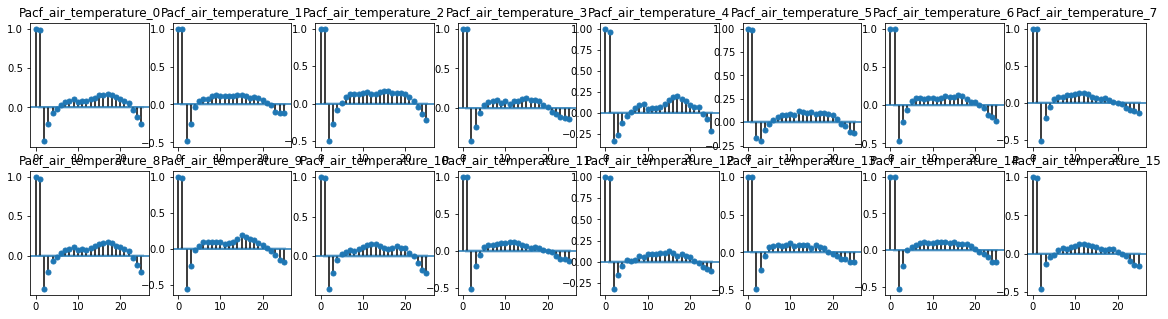

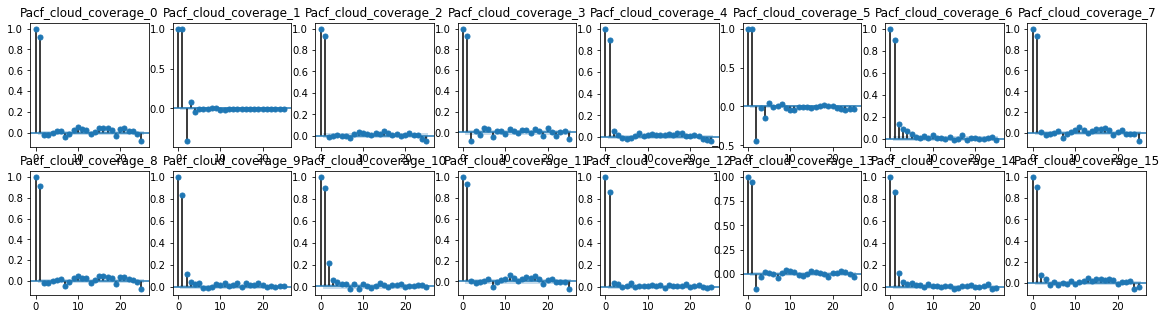

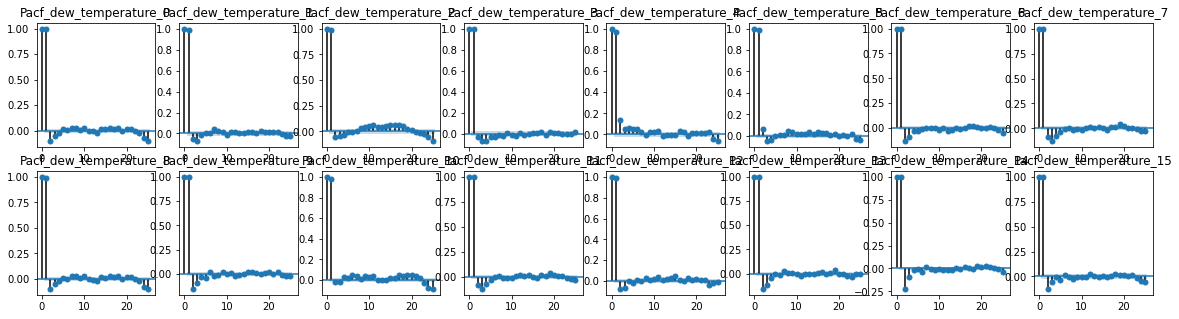

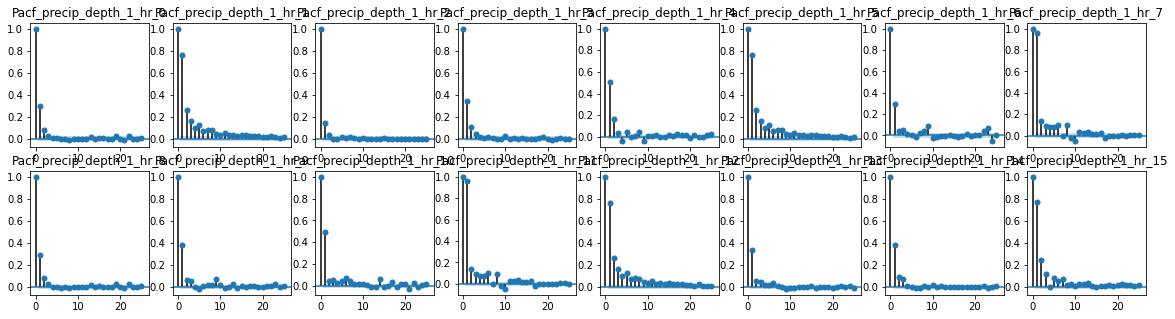

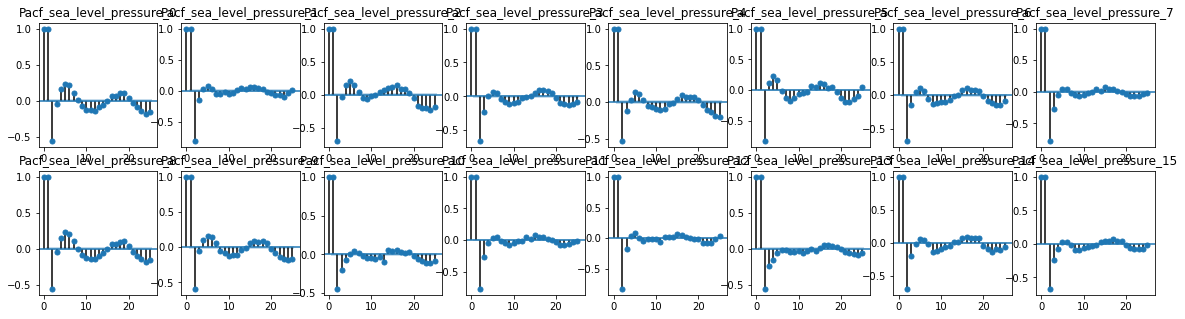

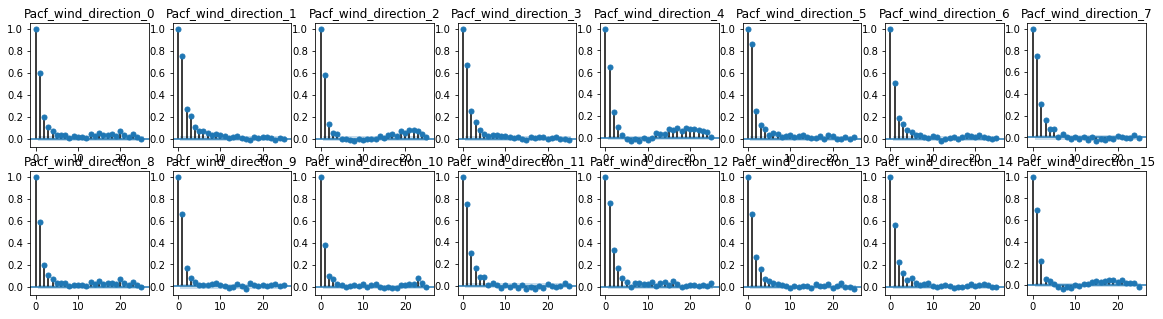

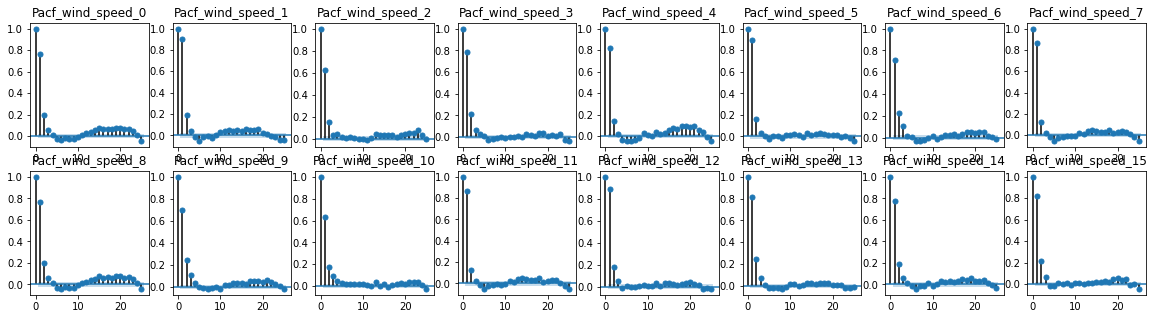

In [40]:
cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
weather_train_df.set_index('timestamp')
for col in cols:
    fig, axes = plt.subplots(2,8,figsize=(20,5))
    for sid in weather_train_df.site_id.unique():
        _dfw = weather_train_df[weather_train_df.site_id==sid][col]
        pacf_air_temp = sm.graphics.tsa.plot_pacf(_dfw,lags=25,ax=axes.ravel()[sid],title = 'Pacf_'+col+'_'+str(sid))

Column              --> lags
'air_temperature'   --> 1,2
'cloud_coverage'    --> 1
'dew_temperature'   --> 1
'precip_depth_1_hr' --> 1
'sea_level_pressure'--> 1,2
'wind_direction'    --> 1,2
'wind_speed'        --> 1,2

In [131]:
weather_train_df.reset_index(inplace=True)
#weather_train_df.drop(['level_0','index'],axis=1,inplace=True)

,timestamp,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,0,25.0,6.000000,20.0,-1.000000,1019.700012,0.0,0.0
1,2016-01-01 00:00:00,1,3.8,0.000000,2.4,0.461538,1020.900024,240.0,3.1
2,2016-01-01 00:00:00,2,15.6,6.000000,-5.6,0.000000,1015.299988,270.0,3.6
3,2016-01-01 00:00:00,3,10.0,8.000000,2.2,0.000000,1021.099976,350.0,4.1
4,2016-01-01 00:00:00,4,9.4,0.000000,-2.2,0.000000,1021.400024,360.0,3.1
...,...,...,...,...,...,...,...,...,...
140539,2016-12-31 23:00:00,11,-9.6,4.642857,-10.8,5.000000,1004.700012,70.0,4.1
140540,2016-12-31 23:00:00,12,6.5,8.000000,5.3,0.615385,1019.500000,340.0,6.0
140541,2016-12-31 23:00:00,13,-5.6,4.000000,-11.1,0.000000,1009.799988,240.0,3.6
140542,2016-12-31 23:00:00,14,6.1,4.000000,-6.7,-1.000000,1012.400024,190.0,9.8


In [132]:
def add_lag_features(df,col,lag=1):
    df = df.set_index(['site_id','timestamp'])
    df[f'{col}_shift{lag}'] = df.groupby(level=0).shift(lag)[col]
    df[f'{col}_shift{lag}'].fillna(method='bfill',inplace=True)
    return df.reset_index()

In [133]:
def add_roll_mean_features(df,col,window):
    _df = df.set_index(['timestamp']).groupby('site_id').rolling(window).mean()[col]
    _df.fillna(method='bfill',inplace=True)
    return df.set_index(['site_id','timestamp']).join(_df,rsuffix=f'_rollmean_{window}').reset_index()

In [134]:
cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
for col in cols:
    weather_train_df = add_roll_mean_features(weather_train_df,col,6)
    weather_test_df = add_roll_mean_features(weather_test_df,col,6)
    weather_train_df = add_roll_mean_features(weather_train_df,col,24)
    weather_test_df = add_roll_mean_features(weather_test_df,col,24)

In [135]:
for col in cols:
    weather_train_df = add_lag_features(weather_train_df,col,1)
    weather_test_df = add_lag_features(weather_test_df,col,1) 
    weather_train_df = add_lag_features(weather_train_df,col,2)
    weather_test_df = add_lag_features(weather_test_df,col,2)
    weather_train_df = add_lag_features(weather_train_df,col,3)
    weather_test_df = add_lag_features(weather_test_df,col,3)
    weather_train_df = add_lag_features(weather_train_df,col,24)
    weather_test_df = add_lag_features(weather_test_df,col,24)
    weather_train_df = add_lag_features(weather_train_df,col,72)
    weather_test_df = add_lag_features(weather_test_df,col,72)

In [136]:
#weather_test_df.drop(weather_test_df.filter(regex='rollmean_6').columns,axis=1,inplace=True)

In [137]:
#plt.figure(figsize=(13,13))
#sns.heatmap(weather_train_df.corr(),annot=True,cmap="YlGnBu",)

In [138]:
def add_date_features(df):
    df['time'] = df['timestamp'].dt.time
    df['hour'] = df['timestamp'].dt.hour
    df['month'] = df['timestamp'].dt.month
    df['day_of_year'] = df['timestamp'].dt.dayofyear
    df['day_of_week'] = df['timestamp'].dt.dayofweek   
    df['week'] = df['timestamp'].dt.isocalendar().week    
    return df

In [139]:
weather_train_df = add_date_features(weather_train_df)
weather_test_df = add_date_features(weather_test_df)

### Renaming columns

In [140]:
train_df = train_df.rename(columns={"meter": "meter_type", "value": "meter_reading"})
test_df = test_df.rename(columns={"meter": "meter_type", "value": "meter_reading"})

### Converting meter reading to Log Scale

In [141]:
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

## Add agg meter features to train_df & test_df

In [142]:
def aggregate_by_building_id(train_df):
    df_group = train_df.groupby(['building_id','meter_type'])['meter_reading_log1p']
    train_df['meter_build_mean'] = df_group.transform('mean')
    train_df['meter_build_median'] = df_group.transform('median')
    train_df['meter_build_min'] = df_group.transform('min')
    train_df['meter_build_max'] = df_group.transform('max')
    train_df['meter_build_std'] = df_group.transform('std')  
    return train_df

In [143]:
train_df = aggregate_by_building_id(train_df)

In [144]:
def aggregate_by_building_id_test(train_df,test_df):
    df_group = train_df.groupby(['building_id','meter_type'])['meter_reading_log1p']
    test_df['meter_build_mean'] = pd.merge(test_df, df_group.mean().reset_index(), on=['building_id','meter_type'], how='left')\
                                    ['meter_reading_log1p']
    test_df['meter_build_median'] = pd.merge(test_df, df_group.median().reset_index(), on=['building_id','meter_type'], how='left')\
                                    ['meter_reading_log1p']
    test_df['meter_build_min'] = pd.merge(test_df, df_group.min().reset_index(), on=['building_id','meter_type'], how='left')\
                                    ['meter_reading_log1p']
    test_df['meter_build_max'] = pd.merge(test_df, df_group.max().reset_index(), on=['building_id','meter_type'], how='left')\
                                   ['meter_reading_log1p']
    test_df['meter_build_std'] = pd.merge(test_df, df_group.std().reset_index(), on=['building_id','meter_type'], how='left')\
                                  ['meter_reading_log1p']  
    return test_df

In [145]:
test_df = aggregate_by_building_id_test(train_df,test_df)

## Save files

In [146]:
dir = "../data/interim/post_featureEng/"
train_df.to_pickle(dir + "train_df.pickle")
test_df.to_pickle(dir + "test_df.pickle")
weather_train_df.to_pickle(dir + "weather_train_df.pickle")
weather_test_df.to_pickle(dir + "weather_test_df.pickle")
building_metadata_df.to_pickle(dir + "building_metadata_df.pickle")